In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


檢測X欄位異常值，刪除異常值

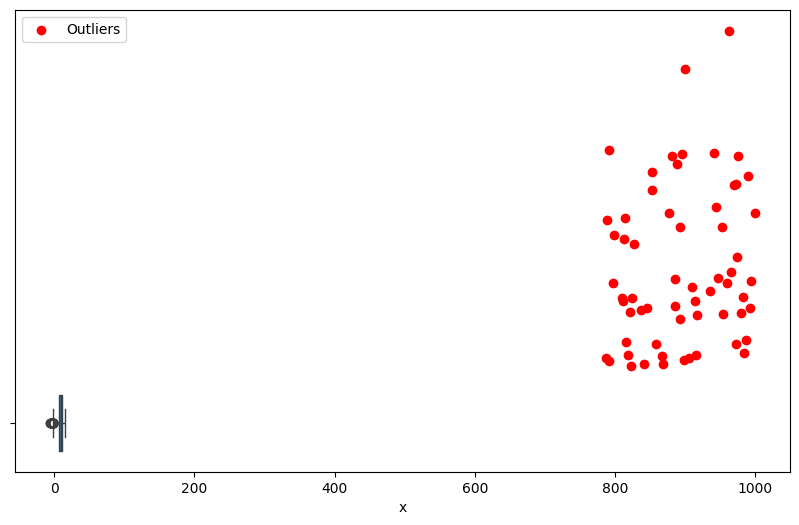

4.8107774999999995


In [2]:
raw_df = pd.read_csv('sizes3.csv', skiprows=0)
x_q1 = raw_df['x'].quantile(0.25)
x_q3 = raw_df['x'].quantile(0.75)
IQR = x_q3 - x_q1
lower_limit = x_q1 - (1.5 * IQR)
upper_limit = x_q3 + (1.5 * IQR)

outliers = raw_df[(raw_df['x'] < lower_limit) | (raw_df['x'] > upper_limit)]
plt.figure(figsize = (10, 6))
sb.boxplot(x=raw_df['x'])
plt.scatter(outliers.index, outliers['x'], color='red', label='Outliers')
plt.legend()
plt.show()
print(IQR)
raw_df = raw_df.drop(outliers.index)

檢測Y欄位異常值，刪除異常值

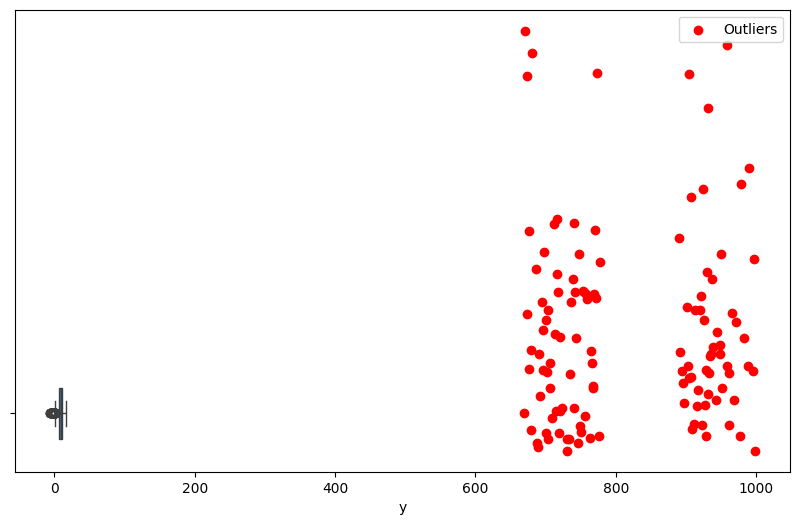

4.101665


In [3]:
y_q1 = raw_df['y'].quantile(0.25)
y_q3 = raw_df['y'].quantile(0.75)
IQR = y_q3 - y_q1
lower_limit = y_q1 - (1.5 * IQR)
upper_limit = y_q3 + (1.5 * IQR)

outliers = raw_df[(raw_df['y'] < lower_limit) | (raw_df['y'] > upper_limit)]
plt.figure(figsize = (10, 6))
sb.boxplot(x=raw_df['y'])
plt.scatter(outliers.index, outliers['y'], color='red', label='Outliers')
plt.legend()
plt.show()
print(IQR)
raw_df = raw_df.drop(outliers.index)

圖無呈現鐘形，不是常態分佈

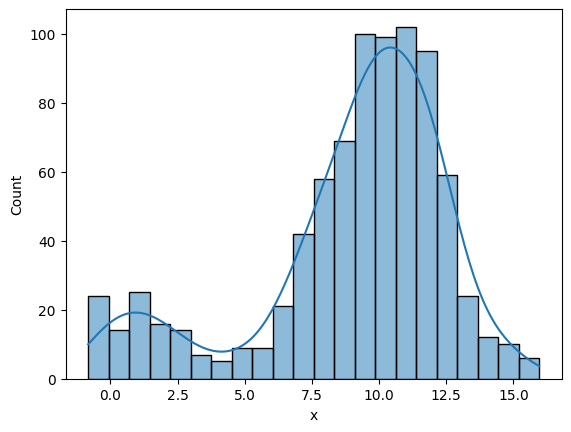

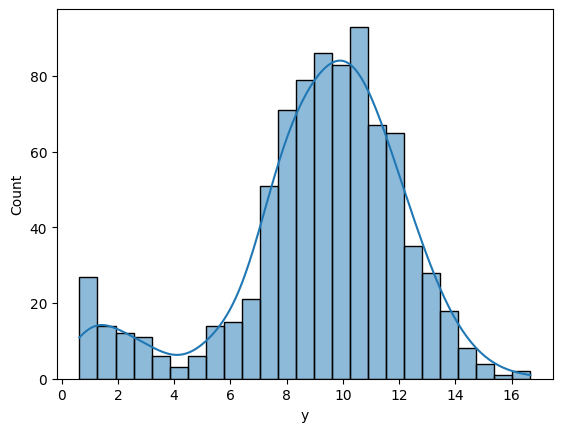

In [4]:
sb.histplot(raw_df['x'], kde=True)
plt.show()
sb.histplot(raw_df['y'], kde=True)
plt.show()

z-score正規化

In [5]:
# from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
y_true = raw_df['class']
raw_df.drop('class', axis = 1, inplace=True)
raw_df = raw_df.apply(zscore)

# scaler = MinMaxScaler()
# raw_df['x'] = scaler.fit_transform(raw_df[['x']])
# raw_df['y'] = scaler.fit_transform(raw_df[['y']])

raw_df
y_true

0      0
1      0
2      0
3      0
4      0
      ..
985    3
987    3
991    3
993    3
995    3
Name: class, Length: 820, dtype: int64

權重分配

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import time
from scipy.stats import entropy
kmeans = KMeans(n_clusters=4, n_init=15, init='k-means++', max_iter=50)
start_time = time.time()
kmeans.fit(raw_df)
end_time = time.time()
execution_time = end_time - start_time
sse = kmeans.inertia_

y_pred = kmeans.labels_.copy()

# y_pred[y_pred == 0] = 3
# y_pred[y_pred == 1] = 4
# y_pred[y_pred == 3] = 2
# y_pred[y_pred == 4] = 1

kscore = accuracy_score(y_true, y_pred)
# print(y_pred)
def cal_entropy(y_true, y_pred):
    #預測的unique值 ex:(兩群) 0、1
    unique_labels = np.unique(y_pred)
    entropies = []
    for label in unique_labels:
        #mask遮罩，讓y_pred選中特定label的資料點
        #(y_pred == label)產生新陣列，如果y_pred陣列與label相同，就True否則False
        #mask = [True,True,True,True,False,False,False,False]
        mask = (y_pred == label)
        cluster_true_labels = y_true[mask]
        #base=2，2的底數計算entropy
        cluster_entropy = entropy(np.bincount(cluster_true_labels), base=2)
        entropies.append(cluster_entropy)

    
    weights = np.bincount(y_pred + 1) / len(y_pred)
    # weights = weights[1:]
    weights = weights[weights != 0]
    weighted_entropy = np.sum(entropies * weights)
    
    print(f"權重分配entropy: {weighted_entropy}")


c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


K-means的視覺化分群結果

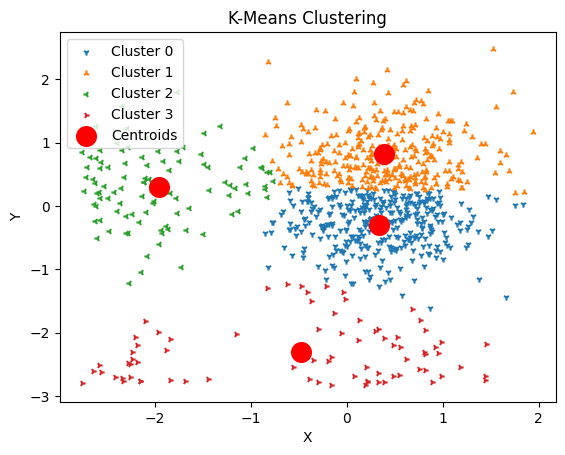

SSE（Sum of Squared Errors）：488.2149031667833
Accuracy：0.5402439024390244
KMeans 運行時間：0.23875832557678223 秒
權重分配entropy: 0.21034537213292498


In [7]:
# 視覺化分群結果
# plt.scatter(raw_df['x'], raw_df['y'], c=kmeans.labels_, s=2, cmap='Spectral')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='o', s=200, c='red', label='Centroids')
for cluster_label in range(kmeans.n_clusters):
    cluster_points = raw_df[kmeans.labels_ == cluster_label]
    # marker = '+' if cluster_label == 0 else 'o' if cluster_label == 1 else '^' 
    if cluster_label == 0:
        marker = '1'
    elif cluster_label == 1:
        marker = '2'
    elif cluster_label == 2:
        marker = '3'
    elif cluster_label == 3:
        marker = '4'

    plt.scatter(cluster_points['x'], cluster_points['y'], s=20, marker=marker, label=f'Cluster {cluster_label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='o', s=200, c='red', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

print(f"SSE（Sum of Squared Errors）：{sse}")
print(f"Accuracy：{kscore}")
print(f"KMeans 運行時間：{execution_time} 秒")
cal_entropy(y_true, y_pred)


找出DBSCAN的最佳EPS

c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sp

<Figure size 3000x3000 with 0 Axes>

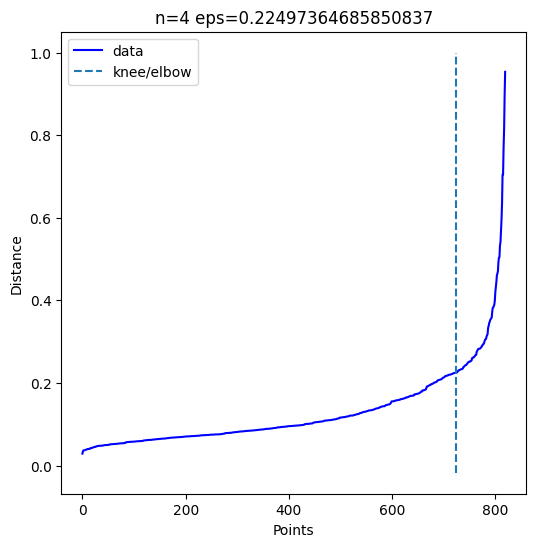

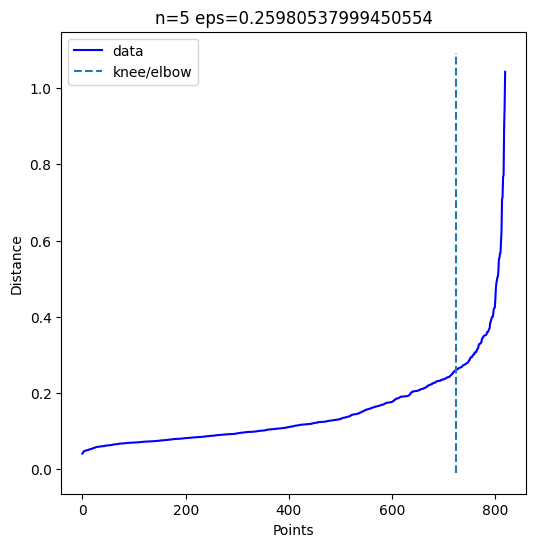

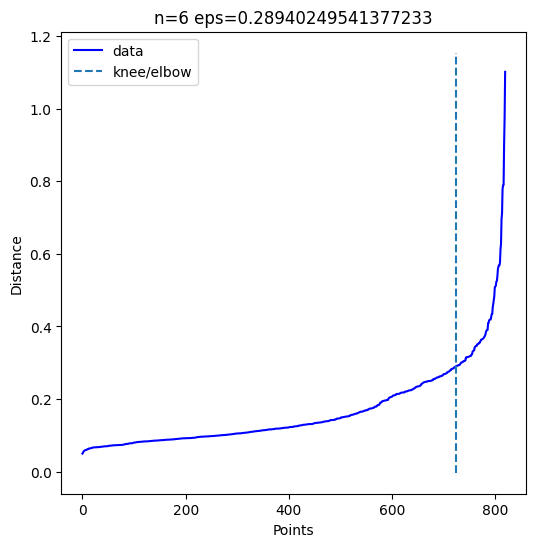

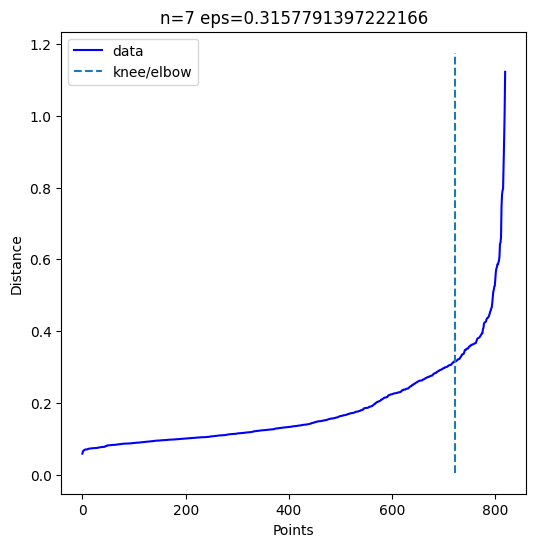

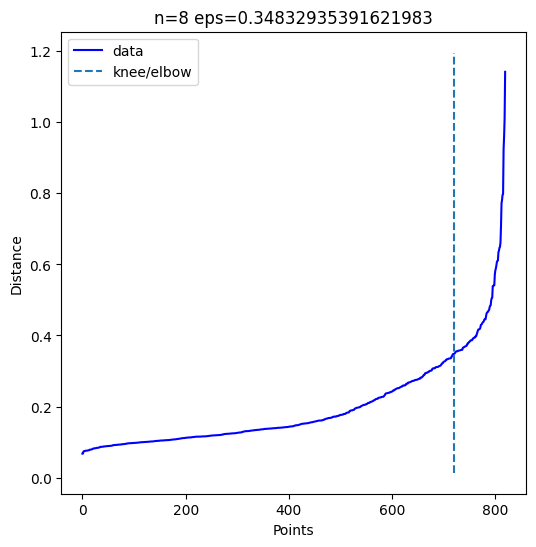

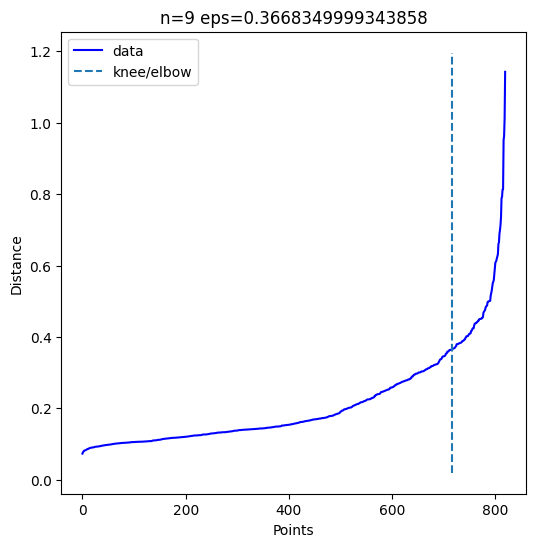

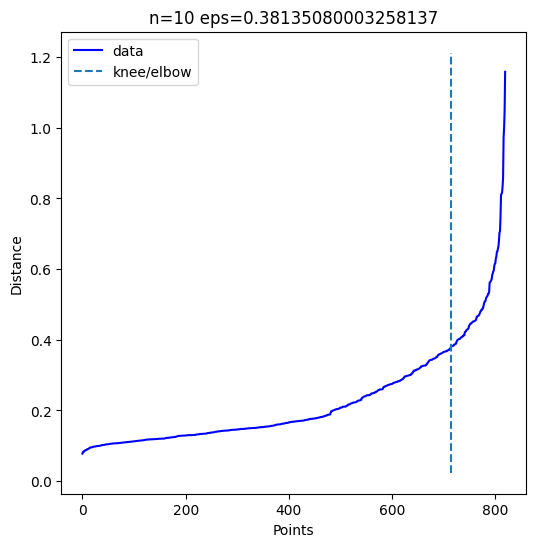

In [8]:
# from sklearn.neighbors import NearestNeighbors

# # 每個點到第四個離居的距離
# k = 4
# neigh = NearestNeighbors(n_neighbors=k)
# distances, _ = neigh.fit(raw_df).kneighbors(raw_df)

# plt.plot(np.arange(len(raw_df)), np.sort(distances[:, -1]))
# plt.title(f'Kdistance Graph (k={k})')
# plt.xlabel('pointToPoint')
# plt.ylabel(f'{k}-Distance')
# plt.show()
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
fig = plt.figure(figsize=(30,30))
for j in range(4,11):

 nearest_neighbors = NearestNeighbors(n_neighbors=j)
 neighbors = nearest_neighbors.fit(raw_df)
 distances, indices = neighbors.kneighbors(raw_df)
 distances = np.sort(distances[:,j-1], axis=0)

 from kneed import KneeLocator 
 i = np.arange(len(distances))

 knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

 knee.plot_knee()
 plt.xlabel("Points")
 plt.ylabel("Distance")
 plt.title(f'n={j} eps={distances[knee.knee]}')

plt.show()

初始化DBSCAN的值

In [9]:
from sklearn.cluster import DBSCAN
start_time = time.time()
clustering = DBSCAN(eps=0.34832935391621983,min_samples = 8) # 一個一個找
labels = clustering.fit_predict(raw_df)
end_time = time.time()
execution_time = end_time - start_time
# print(np.unique(clustering.labels_))
# count = np.count_nonzero(clustering.labels_ == 2)
# print(count)


c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


DBSCAN的視覺化分群以及結果

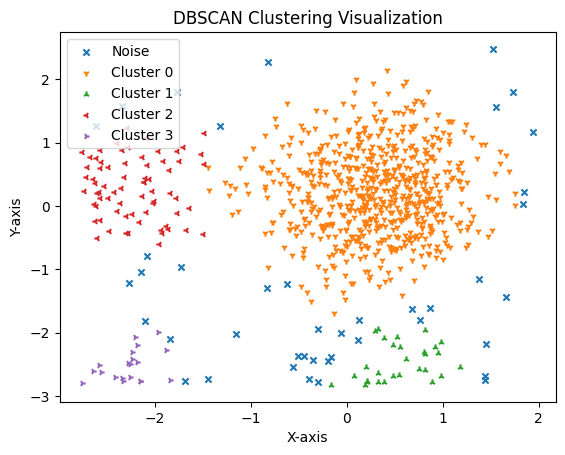

[-1  0  1  2  3]
Accuracy：0.9426829268292682
DBSCAN 運行時間：0.007995128631591797 秒
權重分配entropy: 0.14775493688604907


In [10]:
# 視覺化分群結果

X = raw_df[['x', 'y']].values

markers = ['x', '1', '2', '3', '4']
for i, label in enumerate(np.unique(labels)):
    if label == -1:
        # 噪聲點
        mask = (labels == label)
        plt.scatter(X[mask, 0], X[mask, 1], label=f'Noise', marker=markers[i], s=20)
    else:
        # 正常群
        mask = (labels == label)
        plt.scatter(X[mask, 0], X[mask, 1], label=f'Cluster {label}', marker=markers[i], s=20)

plt.title('DBSCAN Clustering Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()
# print(np.unique(labels))
y_pred = labels.copy()
print(np.unique(y_pred))

# y_pred = y_pred + 1
y_pred[y_pred == -1] = 9
dbscore = accuracy_score(y_true, y_pred)
print(f"Accuracy：{dbscore}")
print(f"DBSCAN 運行時間：{execution_time} 秒")
cal_entropy(y_true, y_pred)

階層式分群

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

model = AgglomerativeClustering(n_clusters=4, linkage='average')
labels = model.fit_predict(raw_df)

c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


聚集性的視覺化分群以及結果

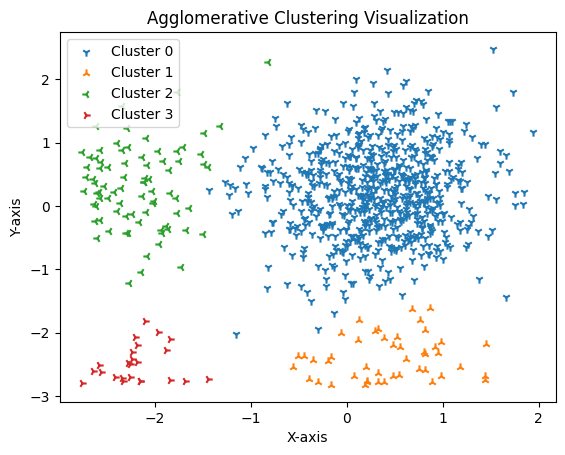

權重分配entropy: 0.10916358430545486
Accuracy：0.9865853658536585


In [12]:
# 視覺化分群結果
# plt.scatter(raw_df['x'], raw_df['y'], c=labels, s=2, cmap='summer')
# plt.title('AgglomerativeClustering')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()
markers = ['1', '2', '3', '4']
for i, label in enumerate(np.unique(labels)):
    mask = (labels == label)
    plt.scatter(X[mask, 0], X[mask, 1], label=f'Cluster {label}', marker=markers[i])
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


y_pred = labels.copy()
# y_pred[y_pred == 0] = 3
# y_pred[y_pred == 1] = 4
# y_pred[y_pred == 3] = 2
# y_pred[y_pred == 4] = 1

ascore = accuracy_score(y_pred, y_true)
cal_entropy(y_true, y_pred)
print(f"Accuracy：{ascore}")




階層式的分群視覺化

c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\UM\anaconda3\envs\bug\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


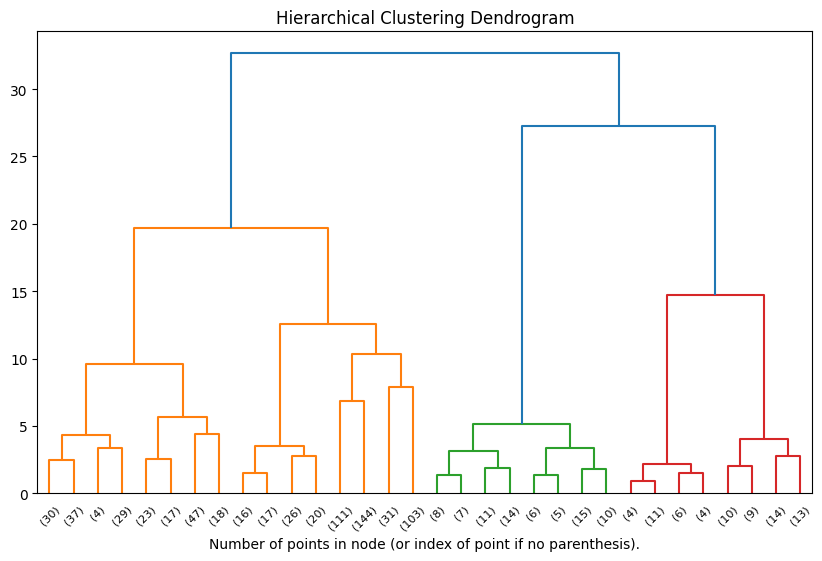

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=2, n_clusters=None)

model = model.fit(raw_df)
plt.figure(figsize=(10, 6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()